In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import gp_lens
import numpy as np
import matplotlib.pyplot as plt
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
lens_obs = gp_lens.LensingPSorPeaks(300,5000, 'KN', redshifts=('10_ng40',), observable_name='PS', bin_center_row=0, binscale='log' )
x, y = lens_obs.get_realizations(model_index=1, verbose=True)
lens_obs.fid = np.mean(y,axis=0)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10_ng40/PS_KN_s1.00_z1.00_ng40.00_b050log.npy


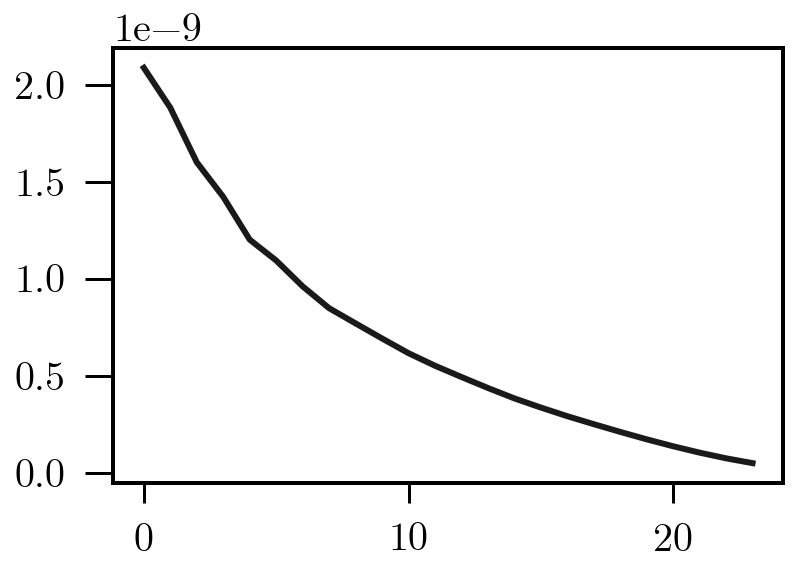

In [4]:
plt.plot(lens_obs.fid)

In [5]:
# powerspec = LensingPSorPeaks(300,3000, 'K', redshifts=('10',), observable_name='PS', bin_center_row=0, binscale='log')
# x, y = powerspec.get_realizations(model_index=0, verbose=True)
# powerspec.fid = np.mean(y,axis=0)
# plt.plot(powerspec.fid)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995/box5/Maps10_ng40/PS_KN_s1.00_z1.00_ng40.00_b050log.npy
(9999, 24)
nr 9999 nb 24 bin 0.99749949989998 sky 0.001225


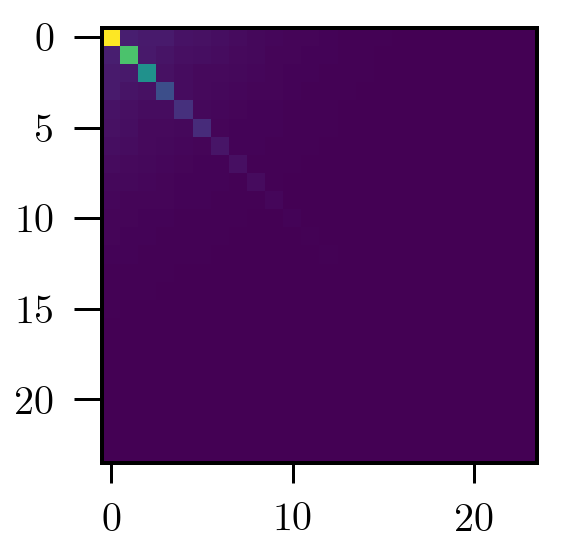

In [6]:
invcov_to_plot = lens_obs.compute_cov(0, verbose=True)
plt.imshow( np.linalg.inv(invcov_to_plot) )

In [10]:
index_list = np.arange(len(lens_obs.params.T))
index_list = np.delete(index_list, 0)

modified_y = [lens_obs.get_realizations(i) for i in index_list]
modified_X = (lens_obs.params.T[index_list]).T

print(len(modified_y), modified_X.shape)

lens_obs.fit(X=modified_X, real_list=modified_y)

100 (3, 100)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0002818 ,  0.00019387,  0.00113719,  0.00076819]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 17, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0002633 ,  0.00048266,  0.0002844 ,  0.0006792 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 27, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [13]:
# set up some constants for prior evaluation
m_nu_min = 0.06  # minimum from oscillation experiments
m_nu_max = 2*np.max(lens_obs.table['M_nu(eV)'])
om_m_min = np.min(lens_obs.table['Omega_m'])
om_m_max = 2*np.max(lens_obs.table['Omega_m'])
A_s_min = np.min(lens_obs.table['10^9*A_s'])
A_s_max = 2*np.max(lens_obs.table['10^9*A_s'])

In [14]:

# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    return lens_obs.likelihood(theta)


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


In [ ]:

import emcee

# set up emcee
ndim, nwalkers = 3, 64
p0 = [lens_obs.params.T[1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# begin sampling, use incremental chain
filename = 'test.out'
f = open(filename, "w")
f.close()

for result in sampler.sample(p0, iterations=5000, storechain=False):
    position = result[0]
    f = open(filename, "a")
    for k in range(position.shape[0]):
        out_str = "{0:4d} {1:s}\n".format(k, ' '.join(map(str, position[k])))
        f.write(out_str)
    f.close()


# Reconstruction Error


/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10_ng40/PS_KN_s1.00_z1.00_ng40.00_b050log.npy
(9999, 24)


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


(-0.02, 0.02)

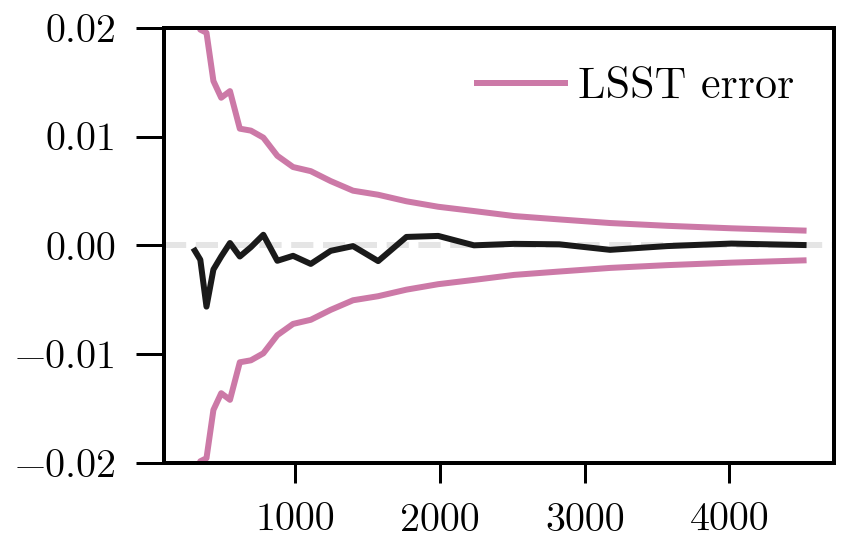

In [8]:
test_model = 1
x, y = lens_obs.get_realizations(model_index=1, verbose=True)
y_true = np.mean(y, axis=0)

plt.axhline(0.0, color=(0,0,0,0.1), ls='dashed')

ys, sigs = lens_obs.GP(lens_obs.params.T[1])
# plt.fill_between( x, (sigs/y_true), (-sigs/y_true), color=default_color_list[3], alpha=0.2)

# plt.plot(ys)
plt.plot( x, (ys-y_true)/y_true, '-')

invcov = lens_obs.compute_cov(0)
cov = np.linalg.inv(invcov)
plt.plot( x, np.sqrt(np.diag(cov))/y_true, label='LSST error', color=default_color_list[4] )
plt.plot( x, -np.sqrt(np.diag(cov))/y_true, color=default_color_list[4] )

plt.legend()
plt.ylim(-0.02, 0.02)

In [11]:
lens_obs.likelihood([0.1,0.3,2.1])

-0.5495868681814222

In [14]:
peaks2 = gp_lens.LensingPSorPeaks(-0.02, 0.06, 'K', redshifts=('10',), observable_name='Peaks', bin_center_row=0)
x, y = peaks2.get_realizations(model_index=1, verbose=True)
peaks2.fid = np.mean(y,axis=0)

index_list = np.arange(len(peaks2.params.T))
index_list = np.delete(index_list, 0)
index_list = np.delete(index_list, 0)

modified_y = [peaks2.get_realizations(i) for i in index_list]
modified_X = (peaks2.params.T[index_list]).T

peaks2.fit(X=modified_X, real_list=modified_y)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10/Peaks_K_s1.00_z1.00_ng13.25_b050.npy


NameError: name 'C' is not defined